In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import lightgbm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
import catboost


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_data.set_index('PassengerId', inplace=True)
test_data.set_index('PassengerId', inplace=True)

In [6]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_data = train_data.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
test_data = test_data.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)


In [8]:
for pclass in train_data['Pclass'].unique():
    for sex in train_data['Sex'].unique():
        train_data.loc[(train_data.Pclass == pclass) & \
                       (train_data.Sex == sex) & \
                       (train_data['Age'].isna()), 'Age'] = \
        train_data.loc[(train_data.Pclass == pclass) & (train_data.Sex == sex), 'Age'].median()

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 55.7+ KB


train_data = train_data.dropna()

In [10]:
features = train_data.drop('Survived', axis=1)
target = train_data['Survived'] 

In [11]:
for col in features.columns:
    if features[col].dtype == 'object':
        features[col] = features[col].astype('category')

In [12]:
features['Pclass'] = features['Pclass'].astype('category') 

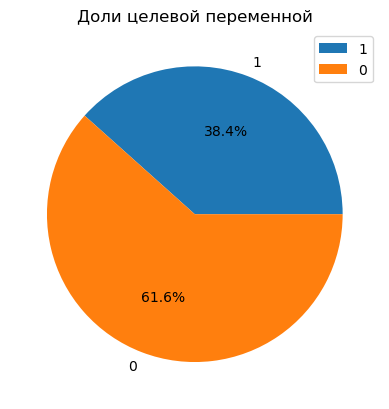

In [13]:
fig, ax = plt.subplots()

ax.pie([train_data['Survived'].mean(), 1 - train_data['Survived'].mean()], labels=['1', '0'], autopct='%1.1f%%')
ax.legend()
ax.set_title('Доли целевой переменной')

plt.show()

In [14]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Survived']

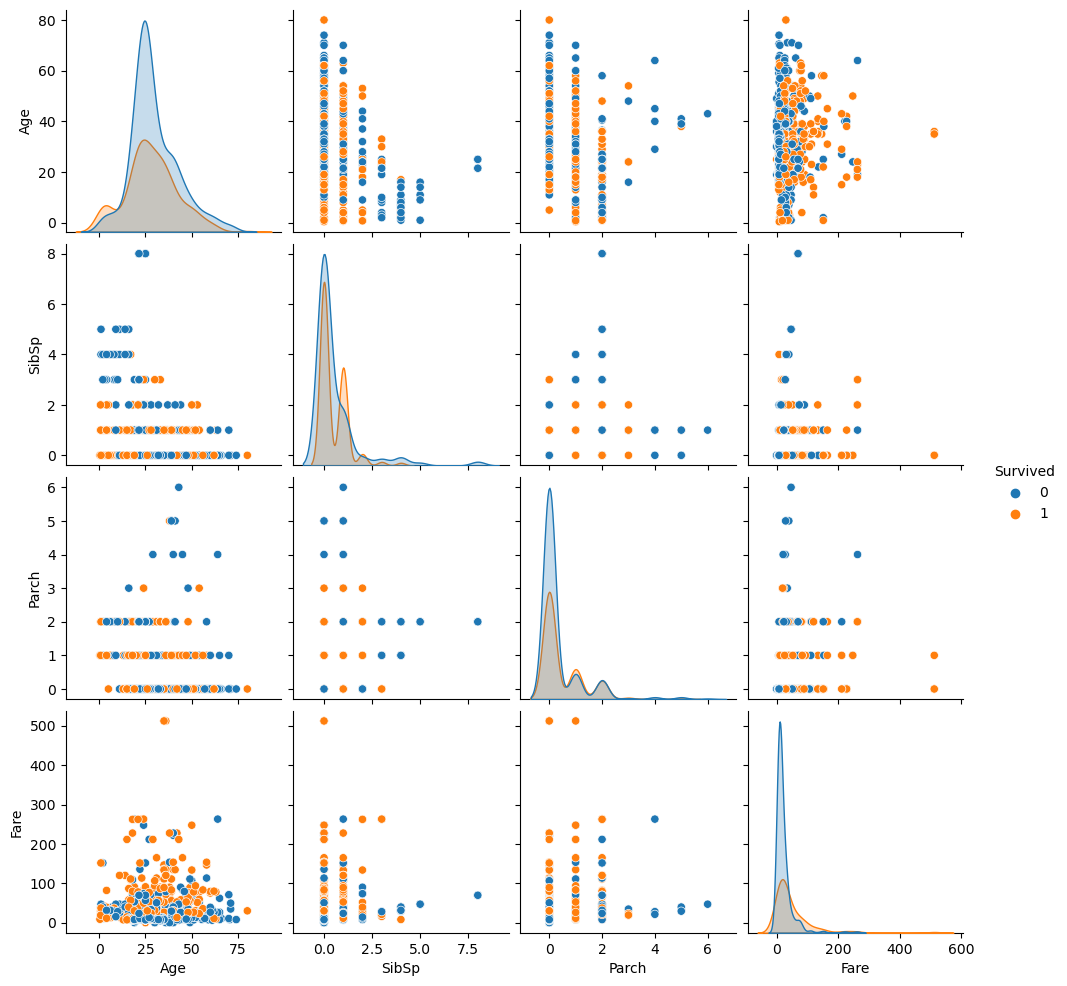

In [15]:
ax = sns.pairplot(train_data[num_features], hue='Survived')

In [16]:
X_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived'] 

In [17]:
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')

In [18]:
X_train['Pclass'] = features['Pclass'].astype('category') 

In [19]:
RANDOM_STATE = 12345

In [20]:
def objective(trial):
    lgbm_model = lightgbm.LGBMClassifier(
        objective='binary',
        boosting_type=trial.suggest_categorical('boosting_type', ['dart', 'gbdt', 'rf']),
        subsample=trial.suggest_float('subsample', .05, 1.,),
        subsample_freq=trial.suggest_int('subsample_freq', 2, 4),
        n_estimators=trial.suggest_int('n_estimators', 10, 300),
        learning_rate=trial.suggest_float('learning_rate', .05, 1., log=True),
        num_leaves=trial.suggest_int('num_leaves', 2, 16),
        max_depth=trial.suggest_int('max_depth', 1, 8),
        colsample_bytree=trial.suggest_float('colsample_bytree', .05, 1.),
        reg_alpha=trial.suggest_float('reg_alpha', .5, 5),
        reg_lambda=trial.suggest_float('reg_lambda', .5, 5),
        is_unbalance=True,
        random_state=RANDOM_STATE,
    )

    # TODO: может стоит поменять на другой сплитер
    sss = StratifiedShuffleSplit(n_splits=5, test_size=.25, random_state=RANDOM_STATE)
    auc_scores = np.zeros(5)
    for i, (t, v) in enumerate(sss.split(X_train, y_train)):
        train_X = X_train.iloc[t]
        train_y = y_train.iloc[t]

        val_X = X_train.iloc[v]
        val_y = y_train.iloc[v]

        lgbm_model.fit(train_X, train_y)
        y_proba = lgbm_model.predict_proba(val_X)[:, 1]
        auc_scores[i] = roc_auc_score(val_y, y_proba)

    return auc_scores.mean()

In [21]:
study = optuna.create_study(direction='maximize', study_name='lgbm_optuna')

In [22]:
%%time
study.optimize(objective, n_trials=100, n_jobs=-1)

CPU times: user 3min 24s, sys: 2min 53s, total: 6min 17s
Wall time: 2min 23s


In [23]:
trial = study.best_trial
print('Лучшие гиперпараметры:')
for param, value in trial.params.items():
    print(f'* {param}: {value}')
print(f'Лучший AUC: {trial.value}')

Лучшие гиперпараметры:
* boosting_type: dart
* subsample: 0.5600265506750842
* subsample_freq: 3
* n_estimators: 248
* learning_rate: 0.19774914128952936
* num_leaves: 9
* max_depth: 8
* colsample_bytree: 0.7328253211480805
* reg_alpha: 0.6695606741033023
* reg_lambda: 4.664992674685512
Лучший AUC: 0.9035053471397045


In [24]:
def objective(trial):
    # TODO: добавить в гиперпараметры аналоги из LightGBM
    catboost_model = catboost.CatBoostClassifier(
        # objective='binary',
        # boosting_type=trial.suggest_categorical('boosting_type', ['dart', 'gbdt', 'rf']),
        subsample=trial.suggest_float('subsample', .05, 1.,),
        # sampling_frequency=trial.suggest_int('sampling_frequency', 2, 4),
        n_estimators=trial.suggest_int('n_estimators', 10, 300),
        learning_rate=trial.suggest_float('learning_rate', .05, 1., log=True),
        # num_leaves=trial.suggest_int('num_leaves', 2, 16),
        max_depth=trial.suggest_int('max_depth', 1, 8),
        # colsample_bytree=trial.suggest_float('colsample_bytree', .05, 1.),
        # reg_alpha=trial.suggest_float('reg_alpha', .5, 5),
        reg_lambda=trial.suggest_float('reg_lambda', .5, 5),
        auto_class_weights='Balanced',
        verbose=0,
        random_state=RANDOM_STATE,
    )
    
    # TODO: может стоит поменять на другой сплитер
    sss = StratifiedShuffleSplit(n_splits=5, test_size=.25, random_state=RANDOM_STATE)
    auc_scores = np.zeros(5)
    for i, (t, v) in enumerate(sss.split(X_train, y_train)):
        train_X = X_train.iloc[t]
        train_y = y_train.iloc[t]

        val_X = X_train.iloc[v]
        val_y = y_train.iloc[v]

        catboost_model.fit(train_X, train_y, cat_features=train_X.select_dtypes('category').columns.to_list())
        y_proba = catboost_model.predict_proba(val_X)[:, 1]
        auc_scores[i] = roc_auc_score(val_y, y_proba)

    return auc_scores.mean()

In [25]:
study = optuna.create_study(direction='maximize', study_name='catboost_optuna')

In [26]:
%%time
study.optimize(objective, n_trials=100, n_jobs=-1)

CPU times: user 2min 29s, sys: 29.3 s, total: 2min 58s
Wall time: 49.3 s


In [27]:
trial = study.best_trial
print('Лучшие гиперпараметры:')
for param, value in trial.params.items():
    print(f'* {param}: {value}')
print(f'Лучший AUC: {trial.value}')

Лучшие гиперпараметры:
* subsample: 0.38771291687819365
* n_estimators: 117
* learning_rate: 0.06960697381464866
* max_depth: 5
* reg_lambda: 2.112332174197222
Лучший AUC: 0.9014513664912578


In [28]:
catboost_model = catboost.CatBoostClassifier(
    subsample=trial.params['subsample'],
    n_estimators=trial.params['n_estimators'],
    learning_rate=trial.params['learning_rate'],
    max_depth=trial.params['max_depth'],
    reg_lambda=trial.params['reg_lambda'],
    auto_class_weights='Balanced',
    verbose=0,
    random_state=RANDOM_STATE,
)
catboost_model = catboost_model.fit(X_train, y_train, cat_features=['Pclass', 'Sex'])

In [29]:
X_test = test_data

y_pred = catboost_model.predict(X_test)

In [30]:
output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': y_pred})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
